<a href="https://colab.research.google.com/github/Neo-glitch/t.f-2.0-practice/blob/master/Fashion_Classification_Using_CNN_and_TfServing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Description

* The 10 classes are
  * 0 : Tshirt/top
  * 1 : Trouser
  * 2 : Pullover
  * 3 : Dress
  * 4 : Coat
  * 5 : Sandal
  * 6 : Shirt
  * 7 : Sneaker
  * 8 : Bag
  * 9 : Ankle Boot

### Link kaggle to Google Colab

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"princeneo","key":"f0986ad408f2ff73081607433165d1ce"}'}

In [ ]:
# make a kaggle dir
!mkdir ~/.kaggle

In [ ]:
# copies kaggle json to kaggle dir
!cp kaggle.json ~/.kaggle/

In [ ]:
# gives permission
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# list of datasets on kaggle(just to check if all is working)
! kaggle datasets list

ref                                                                            title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
datasets/muratkokludataset/acoustic-extinguisher-fire-dataset                  Acoustic Extinguisher Fire Dataset               621KB  2022-04-02 22:59:36           1020        714  0.9375           
datasets/muratkokludataset/rice-image-dataset                                  Rice Image Dataset                               219MB  2022-04-03 02:12:00           1136        660  0.875            
datasets/mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           4007         99  1.0              


In [ ]:
# copied api command to get the kaggle dataset
!kaggle datasets download -d pyim59/fashion-mnist
# !kaggle datasets download -d fengzhongyouxia/fashion-mnist

 51% 17.0M/33.6M [00:00<00:00, 54.7MB/s]
100% 33.6M/33.6M [00:00<00:00, 93.2MB/s]


In [ ]:
# make dir to store the unzipped data
!mkdir fashion_mnist

In [ ]:
# unzip the data into fahsiondir
!unzip fashion-mnist.zip -d fashion_mnist   

Archive:  fashion-mnist.zip
  inflating: fashion_mnist/fashion-mnist_train.csv  


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


fashion_train_df = pd.read_csv("/content/fashion_mnist/fashion-mnist_train.csv")

fashion_train_df.shape

(60000, 785)

In [ ]:
fashion_test_df = fashion_train_df.tail(10000)

fashion_train_df.drop(fashion_train_df.tail(10000).index, inplace =True)


fashion_train_df.shape, fashion_test_df.shape

((40000, 785), (10000, 785))

### Data Viz

In [ ]:
fashion_test_df.head(4)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
40000,0,0,0,0,1,0,0,0,0,0,...,80,92,105,0,0,2,1,0,0,0
40001,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
40002,0,0,0,0,0,0,0,0,0,0,...,198,197,208,106,0,0,0,0,0,0
40003,0,0,0,0,0,0,0,0,43,55,...,111,163,107,0,0,0,0,0,0,0


In [ ]:
# training and test arrays


training = np.array(fashion_train_df, dtype ="float32")
testing = np.array(fashion_test_df, dtype = "float32")

print(training.shape)
training

(40000, 785)


array([[2., 0., 0., ..., 0., 0., 0.],
       [9., 0., 0., ..., 0., 0., 0.],
       [6., 0., 0., ..., 0., 0., 0.],
       ...,
       [8., 0., 0., ..., 0., 0., 0.],
       [2., 0., 0., ..., 0., 0., 0.],
       [3., 0., 0., ..., 0., 0., 0.]], dtype=float32)

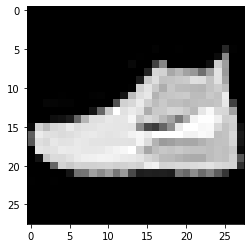

In [ ]:
i = random.randint(1, 60000)


# gets the training instance from the 2d array and get from val second col down
# since first col is the class
plt.imshow(training[i, 1:].reshape(28,28), cmap ="gray")


In [ ]:
label = training[i, 0]
label

7.0

In [ ]:
labels = ["Tshirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Skirt", "Sneakers", "Bag", "Ankle Boot"]

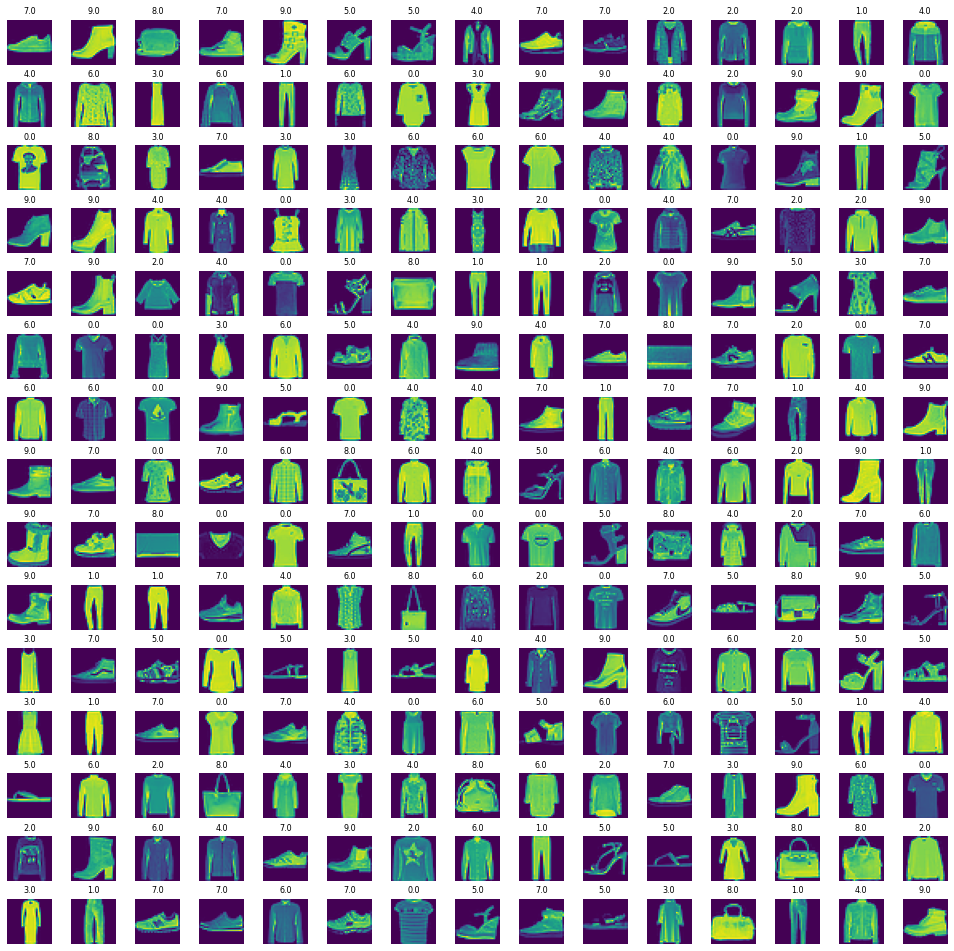

In [ ]:
w_grid = 15
l_grid = 15

fig, axes = plt.subplots(l_grid, w_grid, figsize = (17, 17))

axes = axes.ravel()   # flattens 15 * 15 matrix into 225 array

n_training = len(training)

for i in np.arange(0, w_grid * l_grid):   # create even spaced var, from 0 - 255 with step of 1
  index = np.random.randint(0, n_training)

  axes[i].imshow(training[index, 1:].reshape(28,28))
  axes[i].set_title(training[index, 0], fontsize = 8)
  axes[i].axis("off")

plt.subplots_adjust(hspace=0.4)

### Train Model and Eval

In [ ]:
x_train = training[:, 1:] / 255.
y_train = training[:, 0]

x_test = testing[:, 1:] / 255.
y_test = testing[:, 0]


# * helps to unpack our tuple(intermediate python stuff...lol)
x_train = x_train.reshape(x_train.shape[0], *(28, 28, 1))
x_test = x_test.reshape(x_test.shape[0], *(28, 28, 1))

x_train.shape

(40000, 28, 28, 1)

In [ ]:
cnn = tf.keras.models.Sequential([
   # 28, 28, 1 and 1 means gray scale
   tf.keras.layers.Conv2D(32, (3,3), activation="relu", input_shape = (28, 28, 1)),
   tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
   tf.keras.layers.MaxPooling2D(2,2),
   tf.keras.layers.Conv2D(64, (3,3), activation="relu"),
   tf.keras.layers.Flatten(),
   tf.keras.layers.Dense(64, activation ="relu"),
   tf.keras.layers.Dense(10, activation ="softmax")
])

cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)               0

In [ ]:
cnn.compile(loss="sparse_categorical_crossentropy", optimizer="Adam", metrics = ["accuracy"])


epochs_hist = cnn.fit(x_train, y_train, epochs = 20)

Epoch 1/20
1250/1250 [==============================] - 18s 5ms/step - loss: 0.5645 - accuracy: 0.7913
Epoch 2/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3616 - accuracy: 0.8676
Epoch 3/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3070 - accuracy: 0.8878
Epoch 4/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2749 - accuracy: 0.8977
Epoch 5/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2479 - accuracy: 0.9071
Epoch 6/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2262 - accuracy: 0.9167
Epoch 7/20
1250/1250 [==============================] - 4s 4ms/step - loss: 0.2087 - accuracy: 0.9219
Epoch 8/20
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1907 - accuracy: 0.9296
Epoch 9/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.1742 - accuracy: 0.9359
Epoch 10/20
1250/1250 [==============================] - 4s 3ms/step - loss: 0.15

In [ ]:
predictions = cnn.predict(x_test)

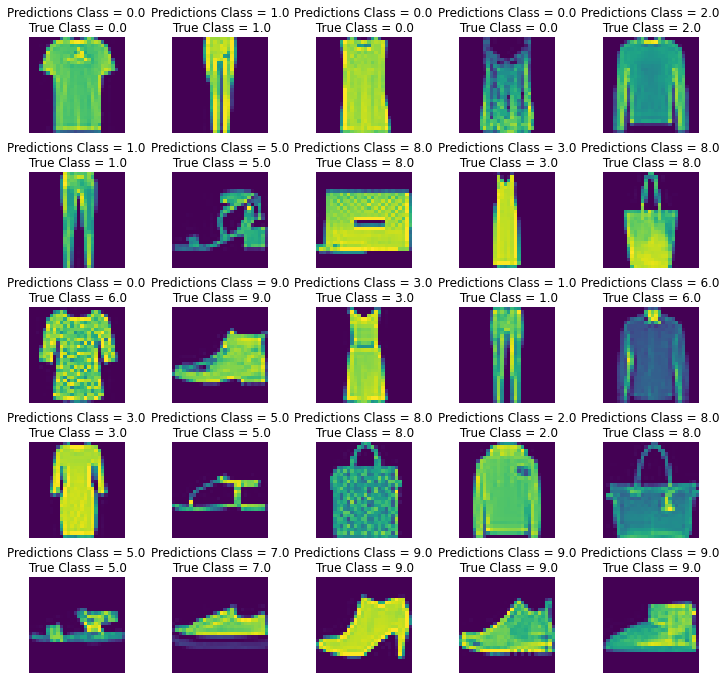

In [ ]:
l = 5
w = 5
fig, axes = plt.subplots(l, w, figsize = (12, 12))

axes = axes.ravel()

for i in np.arange(0, l*w):
  axes[i].imshow(x_test[i].reshape(28, 28))
  axes[i].set_title("Predictions Class = {:.1f}\n True Class = {:0.1f}".format(np.argmax(predictions[i]), y_test[i]))
  axes[i].axis("off")

plt.subplots_adjust(wspace=0.5)

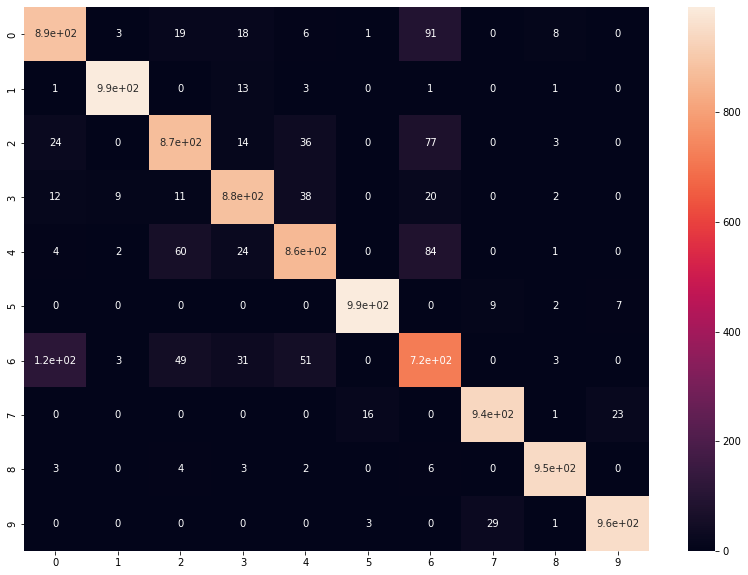

In [ ]:
from sklearn.metrics import confusion_matrix

# predictions on vertical columns and actual on horizontal rows
cm = confusion_matrix(y_test, np.array([np.argmax(prediction) for prediction in predictions]))
plt.figure(figsize = (14, 10))
sns.heatmap(cm, annot = True)

In [ ]:
from sklearn.metrics import classification_report

num_classes = 10

target_names = ["class {}".format(i) for i in range(num_classes)]

# classification report based on each class
print(classification_report(y_test, np.array([np.argmax(prediction) for prediction in predictions]), 
                            target_names = target_names))

              precision    recall  f1-score   support

     class 0       0.85      0.86      0.85      1032
     class 1       0.98      0.98      0.98      1011
     class 2       0.86      0.85      0.85      1028
     class 3       0.90      0.91      0.90       973
     class 4       0.86      0.83      0.85      1037
     class 5       0.98      0.98      0.98      1009
     class 6       0.72      0.74      0.73       972
     class 7       0.96      0.96      0.96       981
     class 8       0.98      0.98      0.98       967
     class 9       0.97      0.97      0.97       990

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



### Save the Model

In [ ]:
# build a saved_model in structure that can be used in tf serving for deployment

import json
import os
import tempfile
import random

# create temp storage dir of saving model
model_dir = "/content" + tempfile.gettempdir()

model_dir

'/content/tmp'

In [ ]:
# specify the model version number
version = 1

export_path = os.path.join(model_dir, str(version))
print(f"export path = {export_path}")

export path = /content/tmp/1


In [ ]:
# save model
# if dir already exists, del it with !rm and create a new one
if (os.path.isdir(export_path)):
  print("Path already exists with a model, cleaning ...")
  !rm -r {export_path}


# save model for serving
tf.keras.models.save_model(
    cnn,
    export_path,
    overwrite=True,
    include_optimizer=True,
    save_format=None,
    signatures=None,
    options=None
)


INFO:tensorflow:Assets written to: /content/tmp/1/assets


### Serve Model to TF Serving

In [ ]:
# get info of the saved model i.e metaGraphDef(the models) and SignatureDefs(methods I can call) in model
!saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['conv2d_input'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 28, 28, 1)
        name: serving_default_conv2d_input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['dense_1'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 10)
        name: StatefulPartitionedCall:0
  Method name is: tensorflow/serving/predict

Concrete Functions:
  Function Name: '__call__'
    Option #1
      Callable with:
        Argument #1
          conv2d_

In [ ]:
# serve the model

import sys
# We need sudo prefix if not on a Google Colab.
if 'google.colab' not in sys.modules:
  SUDO_IF_NEEDED = 'sudo'
else:
  SUDO_IF_NEEDED = ''


!echo "deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal" | {SUDO_IF_NEEDED} tee /etc/apt/sources.list.d/tensorflow-serving.list && \
curl https://storage.googleapis.com/tensorflow-serving-apt/tensorflow-serving.release.pub.gpg | {SUDO_IF_NEEDED} apt-key add -
!{SUDO_IF_NEEDED} apt update

deb http://storage.googleapis.com/tensorflow-serving-apt stable tensorflow-model-server tensorflow-model-server-universal
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2943  100  2943    0     0   143k      0 --:--:-- --:--:-- --:--:--  143k
OK
Hit:1 http://storage.googleapis.com/tensorflow-serving-apt stable InRelease
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic 

In [ ]:
# install tf Model Server
!apt-get install tensorflow-model-server

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tensorflow-model-server is already the newest version (2.8.0).
The following packages were automatically installed and are no longer required:
  libnvidia-common-460 nsight-compute-2020.2.0
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 65 not upgraded.


In [ ]:
# creates a system environ var that will be used in getting access to our model
os.environ["MODEL_DIR"] = model_dir

In [ ]:
%%bash --bg
nohup tensorflow_model_server \
  --rest_api_port=8501 \
  --model_name=fashion_mnist \
  --model_base_path="${MODEL_DIR}" >server.log 2>&1

Starting job # 4 in a separate thread.


In [ ]:
!tail server.log

[warn] getaddrinfo: address family for nodename not supported
[evhttp_server.cc : 245] NET_LOG: Entering the event loop ...


### Make Requests using TF Serving

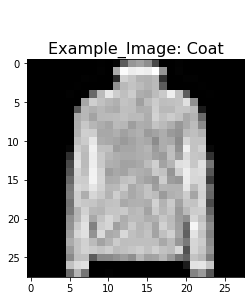

In [ ]:
def show(idx, title):
  plt.figure()
  plt.imshow(x_test[idx].reshape(28, 28), cmap ="gray")
  plt.title(f"\n\n{title}", fontdict = {"size": 16})

index = random.randint(0, len(x_test) -1)
show(index, f"Example_Image: {labels[int(y_test[index])]}")

In [ ]:
y_test[index]

9.0

In [ ]:
# create json request obj with 3 inferences(3 samples of x_test)
data = json.dumps({
    "signature_name": "serving_default",
    "instances": x_test[0:3].tolist()
})

print(data)

{"signature_name": "serving_default", "instances": [[[[0.0], [0.0], [0.0], [0.003921568859368563], [0.0], [0.0], [0.0], [0.0], [0.0], [0.3607843220233917], [0.7333333492279053], [0.6784313917160034], [0.3333333432674408], [0.027450980618596077], [0.027450980618596077], [0.2549019753932953], [0.5686274766921997], [0.8078431487083435], [0.6823529601097107], [0.2705882489681244], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0.054901961237192154], [0.6431372761726379], [0.8980392217636108], [0.8901960849761963], [0.7921568751335144], [0.8078431487083435], [0.9490196108818054], [0.9921568632125854], [0.9960784316062927], [0.9686274528503418], [0.8823529481887817], [0.7450980544090271], [0.8313725590705872], [0.8941176533699036], [0.843137264251709], [0.3764705955982208], [0.0], [0.0], [0.003921568859368563], [0.0], [0.0], [0.0]], [[0.0], [0.0], [0.0], [0.007843137718737125], [0.0], [0.08235294371843338], [0.7843137383460999], [0.807843

In [ ]:
import requests


# make request to our tf end point
headers = {"content-type": "application/json"}
json_response = requests.post("http://localhost:8501/v1/models/fashion_mnist:predict", data = data, headers=headers)
predictions = json.loads(json_response.text)["predictions"]

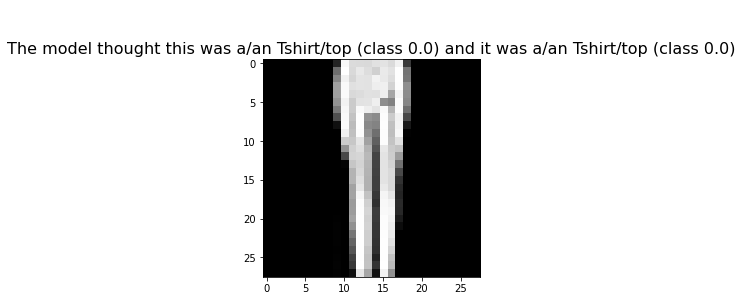

In [ ]:
show(
    1,
     "The model thought this was a/an {} (class {}) and it was a/an {} (class {})".format(
         labels[np.argmax(predictions[2])], y_test[2], labels[int(y_test[2])], y_test[2]
     )
)

In [ ]:
np.argmax(predictions[2])

0

In [ ]:
y_test[2]

0.0